In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-10-25 12:53:38.034861: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-25 12:53:44.301627: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-25 12:53:44.342625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-10-25 12:53:44.342665: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-25 12:53:44.344793: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-25 12:53:44.346930: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [ ]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [4]:
dataset.x_size

20000

In [5]:
from turing.loss_functions import PDE_Parameter, Parameter_Type
#from turing.utils import Simulation

In [6]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm = L2()
l_inf_norm = L_Inf()

In [21]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)

In [22]:
model = tu.TINN(pinn, 
                pde_loss, 
                loss = l2_norm+ l_inf_norm,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.99,
                loss_penalty_power=1,
                print_precision=".10f")

In [23]:
results = model.train(epochs=8000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=1e-3,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 2.1555156708
total loss: 17.0891307042, total regularisd loss (sum of batches): 98.1351196059
obs u loss: 14.0991380719, obs v loss: 2.9896203812
pde u loss: 0.0003491029, pde v loss: 0.0000231481
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 35.62s

Start of epoch 200
Training observations acc over epoch: 1.6479549408
total loss: 6.5918208611, total regularisd loss (sum of batches): 89.4488094940
obs u loss: 6.3342001253, obs v loss: 0.2576196532
pde u loss: 0.0000005285, pde v loss: 0.0000005541
lambda obs u: 3.5270293735, lambda obs v: 0.1803177662
lambda pde u: 0.1427490153, lambda pde v: 0.1499038451

Time taken: 334.84s

Start of epoch 400
Training observations acc over epoch: 1.6461508274
total loss: 6.5846066135, total regularisd loss (sum of batches): 99.2014734727
obs u loss: 6.3321038967, obs v loss: 0.2524987152
pde u loss: 0.0000016595, pde v


Start of epoch 4400
Training observations acc over epoch: 0.0451314040
total loss: 0.1806221085, total regularisd loss (sum of batches): 3.4941364782
obs u loss: 0.1148884548, obs v loss: 0.0656371610
pde u loss: 0.0000479036, pde v loss: 0.0000485890
lambda obs u: 2.0046193000, lambda obs v: 1.4261204242
lambda pde u: 0.2522491102, lambda pde v: 0.3170111656

Time taken: 321.45s

Start of epoch 4600
Training observations acc over epoch: 0.0421499312
total loss: 0.1686842911, total regularisd loss (sum of batches): 3.1124528733
obs u loss: 0.1002177625, obs v loss: 0.0683819533
pde u loss: 0.0000433495, pde v loss: 0.0000412257
lambda obs u: 1.9381141729, lambda obs v: 1.4909475699
lambda pde u: 0.2547245683, lambda pde v: 0.3162136889

Time taken: 321.41s

Start of epoch 4800
Training observations acc over epoch: 0.0401721150
total loss: 0.1607691107, total regularisd loss (sum of batches): 2.9274540360
obs u loss: 0.0901450214, obs v loss: 0.0705434512
pde u loss: 0.0000415362, pde 

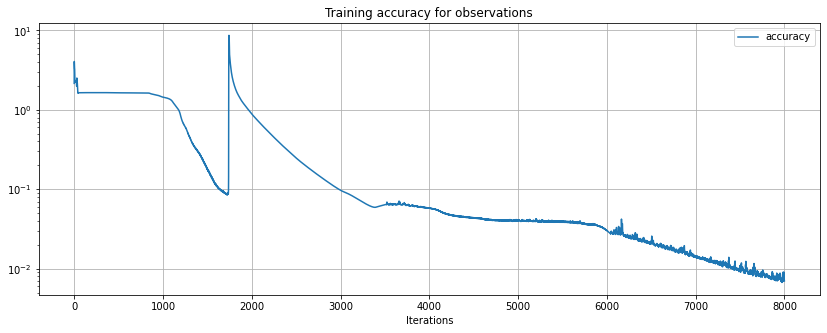

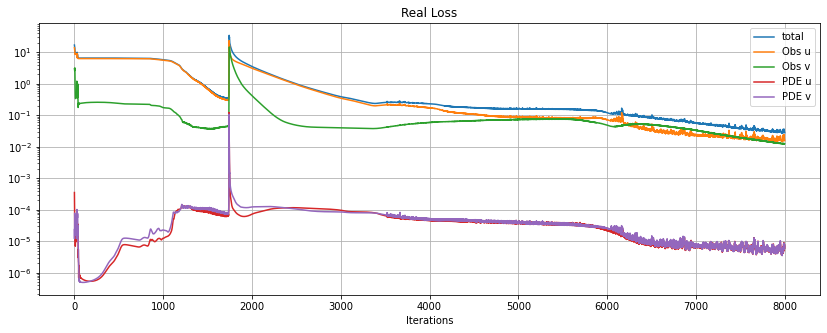

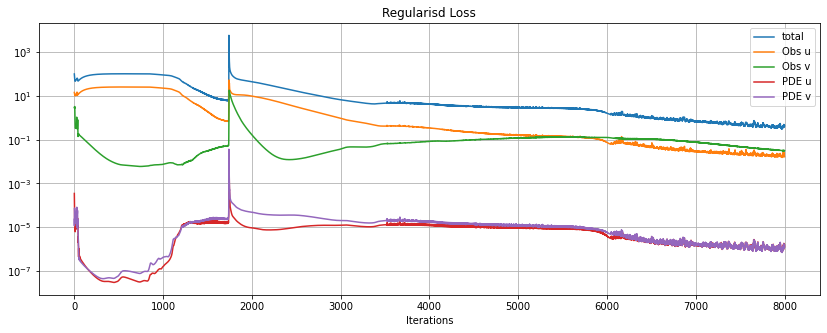

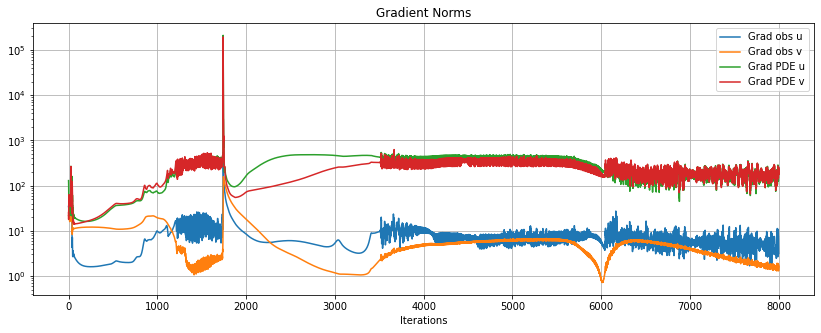

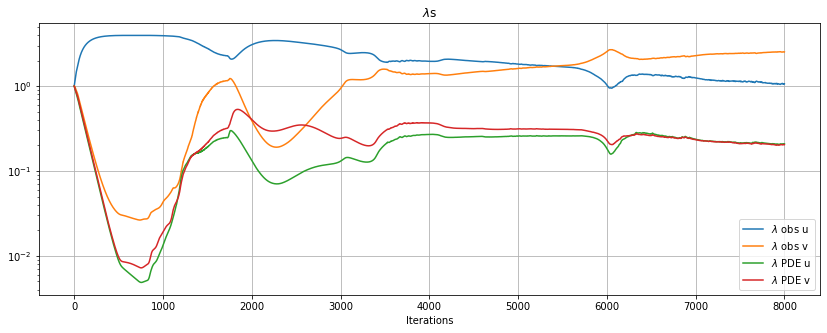

In [24]:
plot_result(results)

In [35]:
results2 = model.train(epochs=4000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-4,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0079263058
total loss: 0.0317154837, total regularisd loss (sum of batches): 0.3759230037
obs u loss: 0.0193953534, obs v loss: 0.0123098734
pde u loss: 0.0000049974, pde v loss: 0.0000052595
lambda obs u: 1.0605148232, lambda obs v: 2.5269102663
lambda pde u: 0.2085731398, lambda pde v: 0.2040017708

Time taken: 1.67s

Start of epoch 200
Training observations acc over epoch: 0.0063352152
total loss: 0.0253522073, total regularisd loss (sum of batches): 0.3561926764
obs u loss: 0.0147657689, obs v loss: 0.0105750901
pde u loss: 0.0000054496, pde v loss: 0.0000058987
lambda obs u: 1.0711206085, lambda obs v: 2.5181328456
lambda pde u: 0.2070254759, lambda pde v: 0.2037210700

Time taken: 319.63s

Start of epoch 400
Training observations acc over epoch: 0.0059677223
total loss: 0.0238794823, total regularisd loss (sum of batches): 0.3191283685
obs u loss: 0.0140358748, obs v loss: 0.0098350144
pde u loss: 0.0000041523, pde v loss:

In [24]:
plot_result(results2,start=3500)

NameError: name 'results2' is not defined

In [47]:
results3 = model.train(epochs=4000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-4,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0018501796
total loss: 0.0074049005, total regularisd loss (sum of batches): 0.0990684337
obs u loss: 0.0053014142, obs v loss: 0.0020993044
pde u loss: 0.0000020196, pde v loss: 0.0000021623
lambda obs u: 1.0509496222, lambda obs v: 2.6216187250
lambda pde u: 0.1640874195, lambda pde v: 0.1633442333

Time taken: 1.69s

Start of epoch 200
Training observations acc over epoch: 0.0014830274
total loss: 0.0059336190, total regularisd loss (sum of batches): 0.0608525512
obs u loss: 0.0039764768, obs v loss: 0.0019556327
pde u loss: 0.0000007312, pde v loss: 0.0000007782
lambda obs u: 1.1510698995, lambda obs v: 2.4645790409
lambda pde u: 0.1920772847, lambda pde v: 0.1922737749

Time taken: 319.60s

Start of epoch 400
Training observations acc over epoch: 0.0013872958
total loss: 0.0055506316, total regularisd loss (sum of batches): 0.0593956074
obs u loss: 0.0037091960, obs v loss: 0.0018399868
pde u loss: 0.0000007157, pde v loss:

In [48]:
model.save("/end/home/rh2310/save_tests", "model_100_by_100_1")

In [49]:
import pickle
symbolic_weights = getattr(optimizer, 'weights')
weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
with open('/end/home/rh2310/save_tests/optimizer_100_by_100_1.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

In [ ]:
with open('/end/home/rh2310/save_tests/optimizer_128_by_128_1.pkl', 'rb') as f:
    weight_values = pickle.load(f)
    
optimizer=keras.optimizers.Adam(learning_rate=5e-4)    
optimizer.set_weights(weight_values)

In [50]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

1024.0


In [51]:
#output_test = pinn(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [29]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

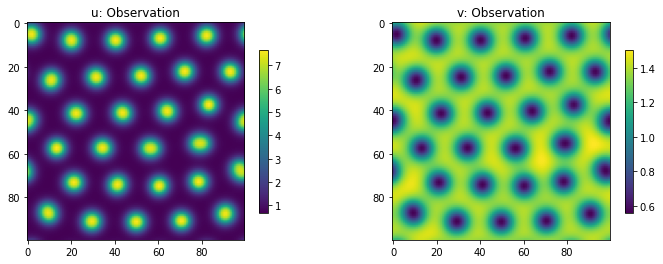

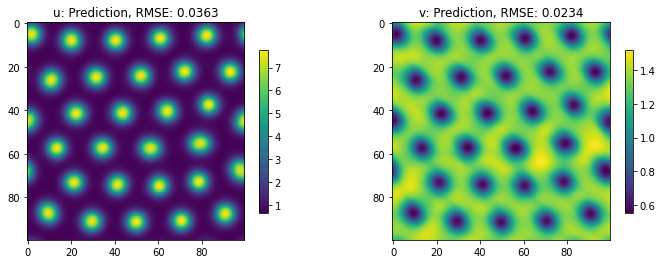

In [52]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [53]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss.residual(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()


In [54]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

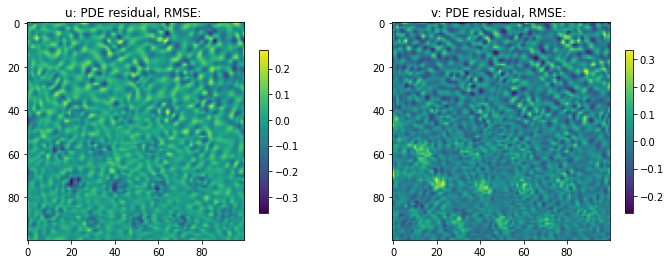

In [55]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

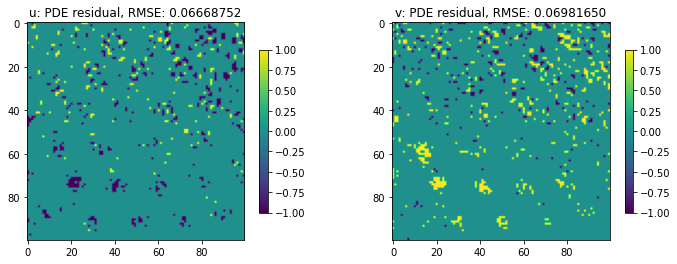

In [58]:
max_L = .12
min_L = -.12

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters estimation

In [2]:
import os

In [5]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [6]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn2 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss2 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype) 
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm2 = L2()
l_inf_norm2 = L_Inf()

In [7]:
optimizer2=keras.optimizers.Adam(learning_rate=5e-4)

In [8]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                loss = l2_norm2+ l_inf_norm2,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.99,
                loss_penalty_power=1,
                print_precision=".10f")

In [9]:
dataset = dataset.cache()

In [10]:
dataset.x_size

20000

In [11]:
results2_1 = model2.train(epochs=20000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-5,
                      optimizer=optimizer2,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-10-21 11:26:34.393689: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-21 11:26:52.390211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 4.2903532982
total loss: 18.7910925450, total regularisd loss (sum of batches): 75.1643701801
obs u loss: 14.2353546511, obs v loss: 2.9260588228
pde u loss: 1.4387026517, pde v loss: 0.1909764195
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
A: 0.99828 B: 0.99819 
Time taken: 40.01s

Start of epoch 200
Training observations acc over epoch: 1.6089261770
total loss: 6.4733050401, total regularisd loss (sum of batches): 88.6368616858
obs u loss: 6.3291842191, obs v loss: 0.1065205673
pde u loss: 0.0161864294, pde v loss: 0.0214138243
lambda obs u: 3.5010818733, lambda obs v: 0.2162489389
lambda pde u: 0.1404221686, lambda pde v: 0.1422470192
A: 1.06722 B: 1.12850 
Time taken: 334.56s

Start of epoch 400
Training observations acc over epoch: 1.6047387123
total loss: 6.4580014222, total regularisd loss (sum of batches): 97.8451444990
obs u loss: 6.3206881663, obs v loss: 0.0982663861
pde u


Start of epoch 4200
Training observations acc over epoch: 0.0183278248
total loss: 0.3579038790, total regularisd loss (sum of batches): 0.8236437858
obs u loss: 0.0268879212, obs v loss: 0.0464233783
pde u loss: 0.1377896052, pde v loss: 0.1468029743
lambda obs u: 1.6582295202, lambda obs v: 1.7924979464
lambda pde u: 0.2725896163, lambda pde v: 0.2766829171
A: 1.17255 B: 2.57646 
Time taken: 321.52s

Start of epoch 4400
Training observations acc over epoch: 0.0149936229
total loss: 0.3021419905, total regularisd loss (sum of batches): 0.6841423617
obs u loss: 0.0255632560, obs v loss: 0.0344112365
pde u loss: 0.1186750352, pde v loss: 0.1234924628
lambda obs u: 1.5260981500, lambda obs v: 1.9325314827
lambda pde u: 0.2683224083, lambda pde v: 0.2730479591
A: 1.17628 B: 2.60611 
Time taken: 321.67s

Start of epoch 4600
Training observations acc over epoch: 0.0136151947
total loss: 0.4599266484, total regularisd loss (sum of batches): 0.7854695445
obs u loss: 0.0281374883, obs v loss:


Start of epoch 8400
Training observations acc over epoch: 0.0021189894
total loss: 0.0860182610, total regularisd loss (sum of batches): 0.1388688597
obs u loss: 0.0060529119, obs v loss: 0.0024230457
pde u loss: 0.0357077396, pde v loss: 0.0418345637
lambda obs u: 1.3967955040, lambda obs v: 2.0571917754
lambda pde u: 0.2631845440, lambda pde v: 0.2828281766
A: 1.18657 B: 2.75327 
Time taken: 321.43s

Start of epoch 8600
Training observations acc over epoch: 0.0018537606
total loss: 0.0497832152, total regularisd loss (sum of batches): 0.0897443109
obs u loss: 0.0052220786, obs v loss: 0.0021929637
pde u loss: 0.0191636351, pde v loss: 0.0232045378
lambda obs u: 1.3790440647, lambda obs v: 2.1251234555
lambda pde u: 0.2332880265, lambda pde v: 0.2625444533
A: 1.18599 B: 2.75582 
Time taken: 321.41s

Start of epoch 8800
Training observations acc over epoch: 0.0016190262
total loss: 0.0411636454, total regularisd loss (sum of batches): 0.0789912285
obs u loss: 0.0042837345, obs v loss:


Start of epoch 12600
Training observations acc over epoch: 0.0022644401
total loss: 0.1294635557, total regularisd loss (sum of batches): 0.1955846676
obs u loss: 0.0074956955, obs v loss: 0.0015620646
pde u loss: 0.0584636973, pde v loss: 0.0619420983
lambda obs u: 1.3728034575, lambda obs v: 2.0360754629
lambda pde u: 0.2796759183, lambda pde v: 0.3114451613
A: 1.17835 B: 2.80483 
Time taken: 321.42s

Start of epoch 12800
Training observations acc over epoch: 0.0030392786
total loss: 0.2120099236, total regularisd loss (sum of batches): 0.3383842975
obs u loss: 0.0106873914, obs v loss: 0.0014697227
pde u loss: 0.0961991961, pde v loss: 0.1036536134
lambda obs u: 1.4998611397, lambda obs v: 1.8377814022
lambda pde u: 0.3149430593, lambda pde v: 0.3474143988
A: 1.17816 B: 2.80722 
Time taken: 321.40s

Start of epoch 13000
Training observations acc over epoch: 0.0007025058
total loss: 0.0158141997, total regularisd loss (sum of batches): 0.0320264126
obs u loss: 0.0018911115, obs v lo


Start of epoch 16800
Training observations acc over epoch: 0.0004118354
total loss: 0.0092369367, total regularisd loss (sum of batches): 0.0182464161
obs u loss: 0.0010778958, obs v loss: 0.0005694458
pde u loss: 0.0040143767, pde v loss: 0.0035752183
lambda obs u: 1.3601493529, lambda obs v: 2.1442151828
lambda pde u: 0.2271328826, lambda pde v: 0.2685025817
A: 1.16986 B: 2.84556 
Time taken: 321.41s

Start of epoch 17000
Training observations acc over epoch: 0.0004626625
total loss: 0.0104064899, total regularisd loss (sum of batches): 0.0228249392
obs u loss: 0.0012264975, obs v loss: 0.0006241524
pde u loss: 0.0044291616, pde v loss: 0.0041266783
lambda obs u: 1.3753000685, lambda obs v: 1.9727510157
lambda pde u: 0.3082938975, lambda pde v: 0.3436550183
A: 1.16952 B: 2.84749 
Time taken: 321.42s

Start of epoch 17200
Training observations acc over epoch: 0.0004105190
total loss: 0.0106558459, total regularisd loss (sum of batches): 0.0178586836
obs u loss: 0.0011116097, obs v lo

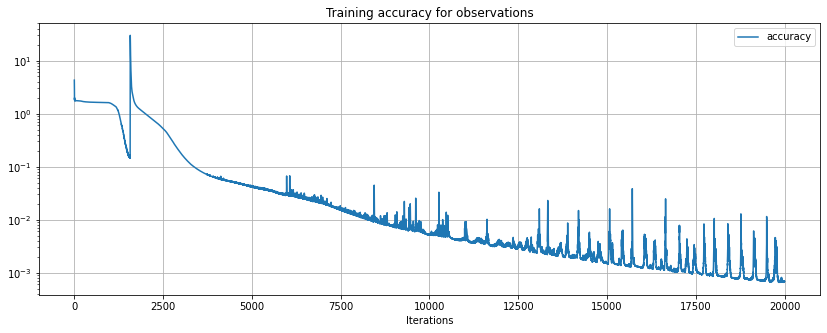

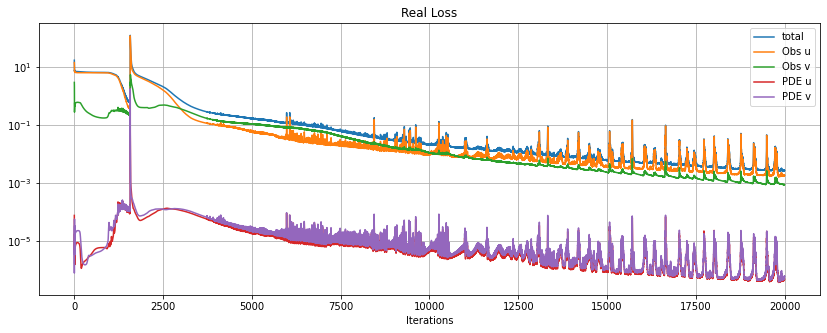

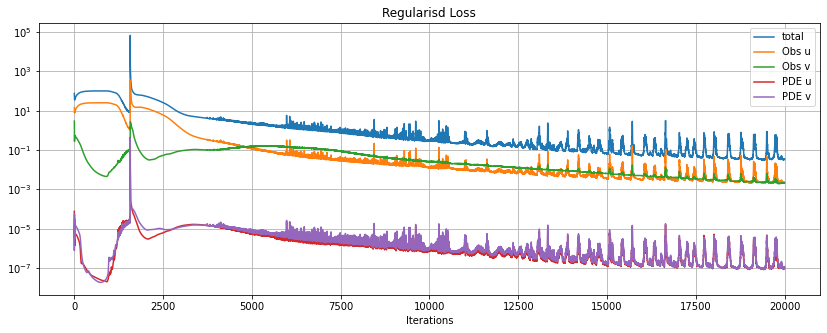

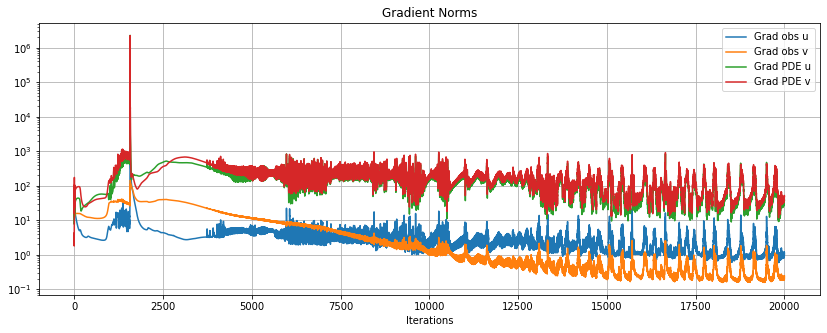

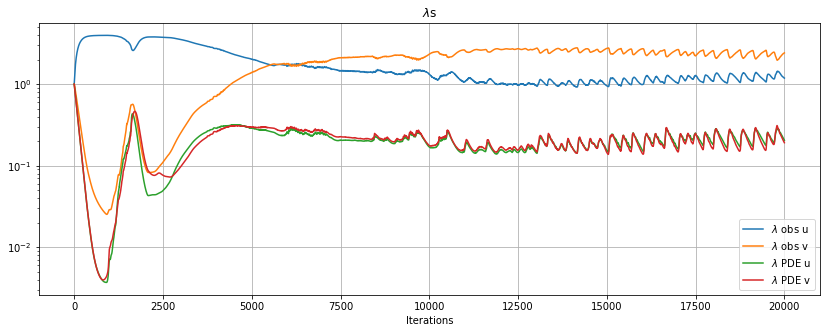

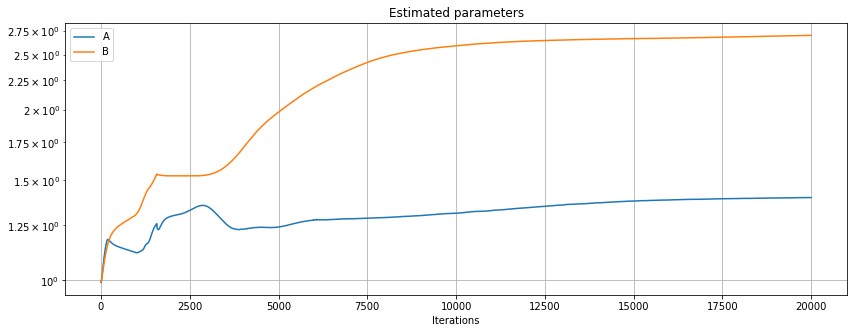

In [29]:
plot_result(results2_1, param_names=["A", "B"])

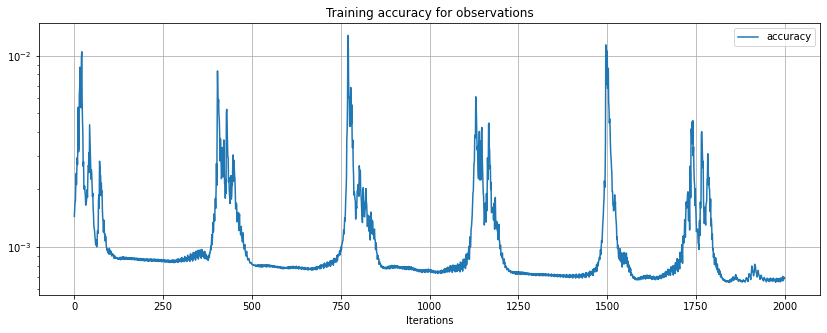

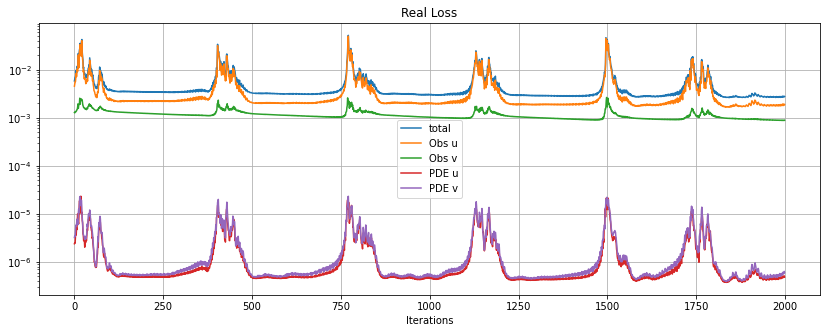

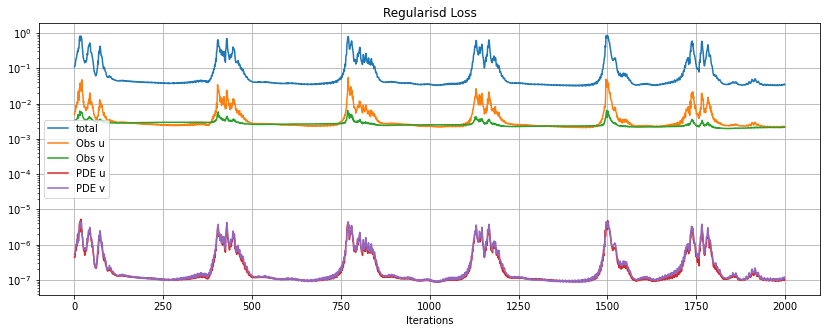

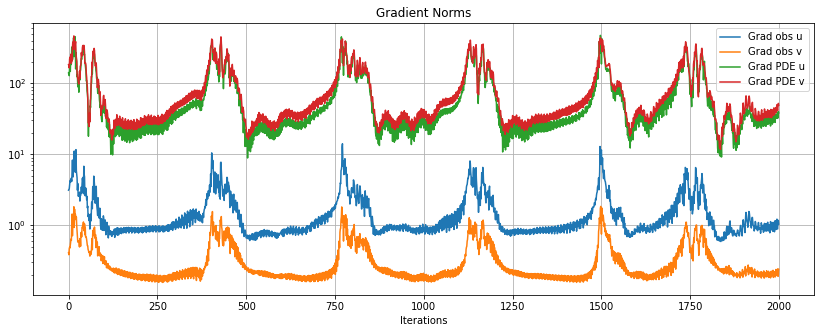

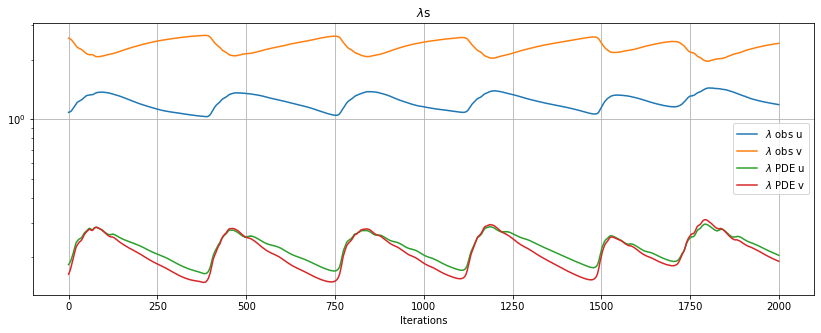

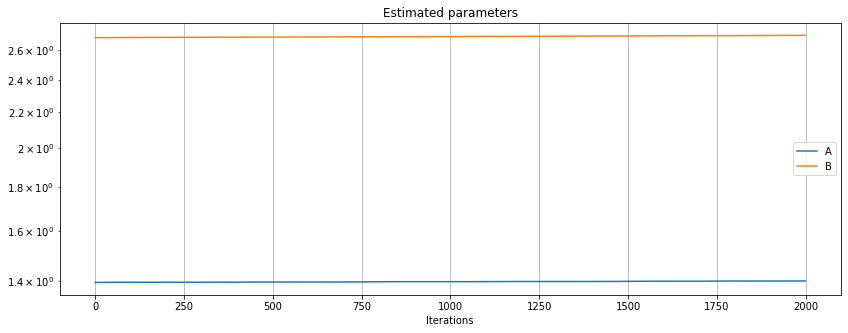

In [25]:
plot_result(results2_1, param_names=["A", "B"], start=18000)

In [28]:
optimizer2.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [30]:
results2_2 = model2.train(epochs=2000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=100,
                      stop_threshold=5e-4,
                      optimizer=optimizer2,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0006409383
total loss: 0.0025648447, total regularisd loss (sum of batches): 0.0336753119
obs u loss: 0.0016902702, obs v loss: 0.0008734830
pde u loss: 0.0000004922, pde v loss: 0.0000005994
lambda obs u: 1.1858410962, lambda obs v: 2.4187194526
lambda pde u: 0.2045522511, lambda pde v: 0.1908872001
A: 1.39954 B: 2.70211 
Time taken: 1.69s

Start of epoch 100
Training observations acc over epoch: 0.0005867729
total loss: 0.0023477374, total regularisd loss (sum of batches): 0.0353546471
obs u loss: 0.0014754493, obs v loss: 0.0008716423
pde u loss: 0.0000003165, pde v loss: 0.0000003293
lambda obs u: 1.4729619716, lambda obs v: 1.7252605312
lambda pde u: 0.4292675524, lambda pde v: 0.3725099448
A: 1.39953 B: 2.70222 
Time taken: 158.73s

Start of epoch 200
Training observations acc over epoch: 0.0005878586
total loss: 0.0023520670, total regularisd loss (sum of batches): 0.0349205388
obs u loss: 0.0014745985, obs v loss: 0.0008

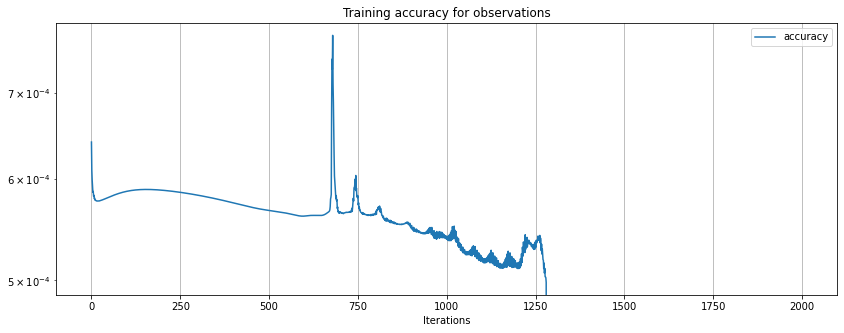

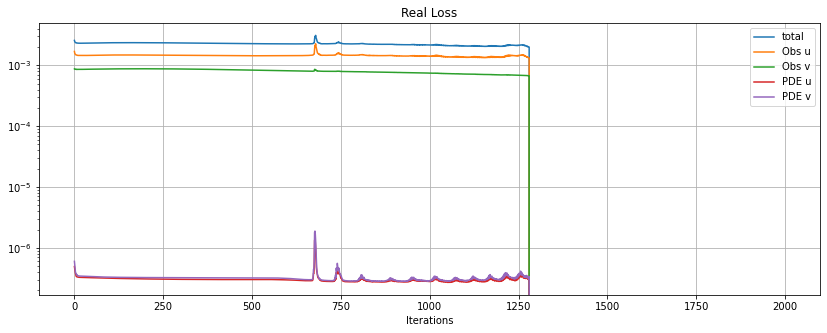

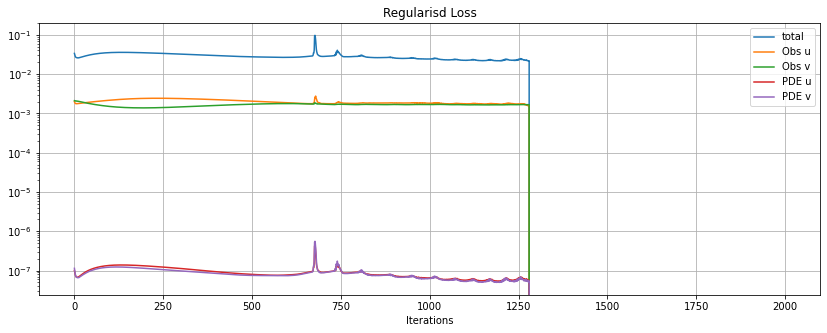

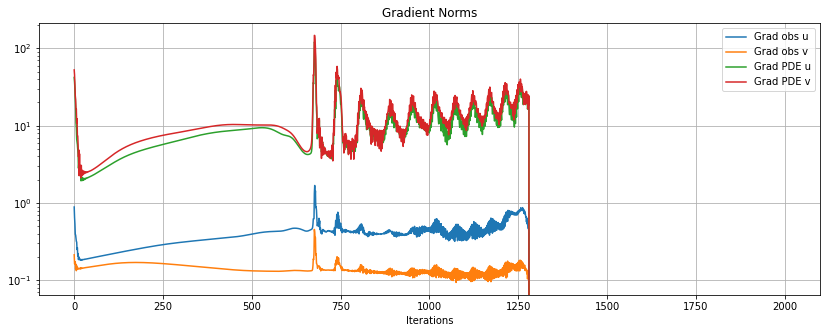

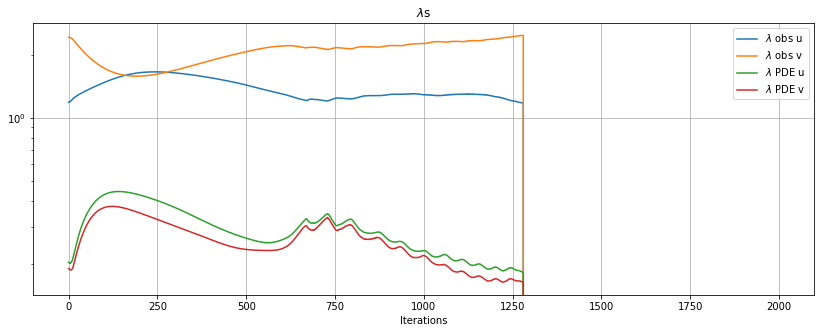

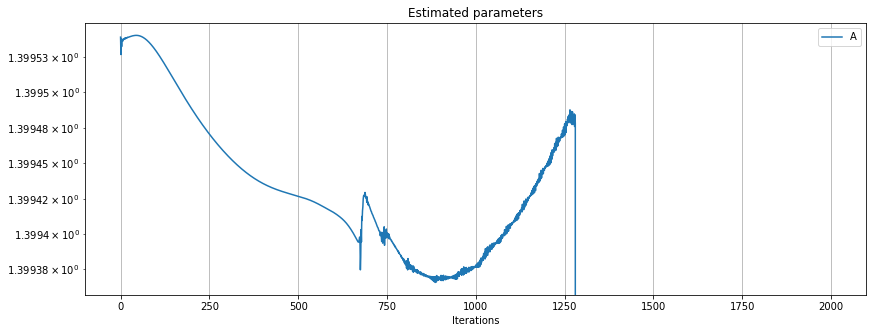

In [52]:
plot_result(results2_2, param_names=["A"])

In [59]:
optimizer2.lr.assign(2.5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [60]:
results2_3 = model2.train(epochs=4000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=100,
                      stop_threshold=9e-5,
                      optimizer=optimizer2,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-10-21 10:49:08.894083: W tensorflow/core/kernels/data/cache_dataset_ops.cc:798] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a int32 tensor [Op:AddV2]

In [49]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

A = 1.3994780827544253
B = 2.7047523447071771


In [23]:
model2.save("/end/home/rh2310/save_tests", "model_100_by_100_2")

In [31]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

1024.0


In [32]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [33]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

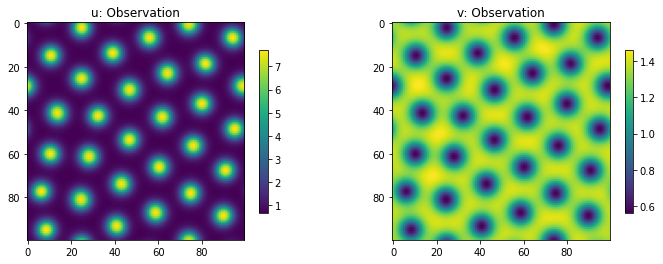

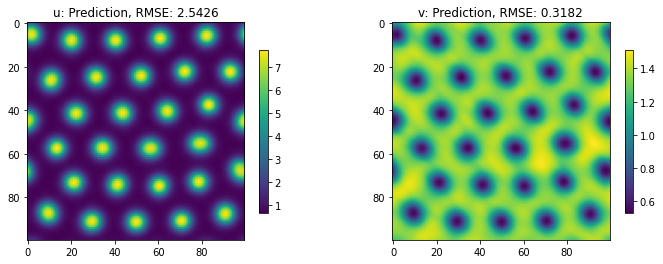

In [34]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [35]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss2.residual(pinn2, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()

In [36]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

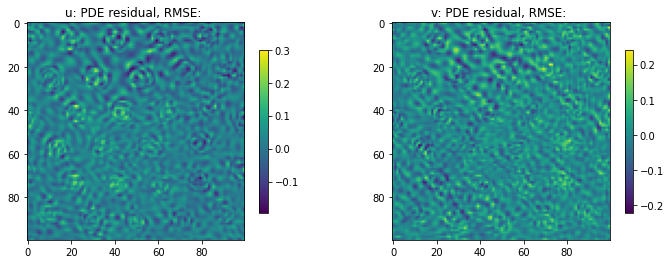

In [37]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

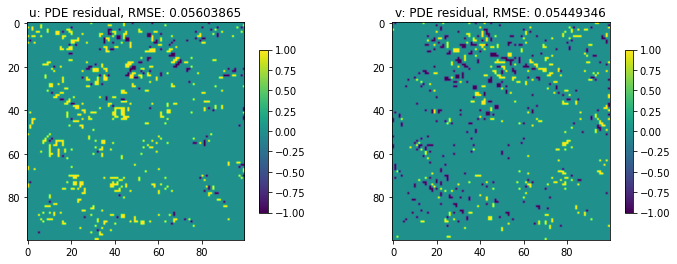

In [39]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

In [57]:
results2_2['loss_obs_u'][results2_2['loss_obs_u'] > 0][-1]

0.0013185408394123777